# Import packages

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from genetic_selection import GeneticSelectionCV

df = pd.read_csv("sph6004_assignment1_data.csv")

Print out data shape to know how many patients and how many indicators

In [40]:
print(df.shape)
df.head()

(50920, 162)


,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,36570066,3,F,79.953141,BLACK/AFRICAN AMERICAN,96.0,104.0,100.083333,103.0,126.0,...,NaN,236.0,318.0,15.0,6.0,5.0,4.0,0.0,157.0,110.0
1,39307659,0,F,78.194169,WHITE - RUSSIAN,72.0,134.0,97.263158,97.0,127.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,82.0
2,38743306,2,F,65.602396,WHITE,60.0,97.0,84.166667,95.0,143.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,62.1
3,32339865,2,F,64.906629,UNKNOWN,59.0,87.0,71.461538,113.0,150.0,...,NaN,NaN,NaN,15.0,1.0,0.0,1.0,1.0,170.0,113.1
4,35526987,2,M,57.438861,WHITE,57.0,100.0,82.387097,81.0,127.0,...,NaN,NaN,NaN,15.0,NaN,0.0,1.0,1.0,178.0,97.4


# Key indicator check
Check whether all patients have aki in their data, otherwise delete that data. Find all patients have aki value

In [41]:
aki_nan_count = 0
for index, row in df.iterrows():
    if row['aki'] not in [0,1,2,3]:
        aki_nan_count += 1
print(aki_nan_count)

0

First, show max and min value of each column to see whether it is rational

In [4]:
# Create a DataFrame for max and min values for each column
df_max = pd.DataFrame(df.max()).transpose()
df_min = pd.DataFrame(df.min()).transpose()

# Concatenate vertically
result_df = pd.concat([df_max, df_min], axis=0)
result_df.head()

,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,39999810,3,M,102.865603,WHITE - RUSSIAN,167.0,280.0,174.740741,195.0,357.0,...,2720.0,22890.0,63325.0,15.0,6.0,5.0,4.0,1.0,226.0,5864.0
0,30000153,0,F,18.002527,AMERICAN INDIAN/ALASKA NATIVE,1.0,36.0,28.5,0.108,34.0,...,6.0,31.0,31.0,3.0,1.0,0.0,1.0,0.0,122.0,1.0


# Data Preprocessing
## Clean column data
Find something unrational, then come with some ranges, searched by online resource.
These following standard is considered for adults as the minimum age is 18 years old
heart rate should be around 40-220
temperature should be around 34-43
glucose should be around 40-200
weight should be around 30-300

In [5]:
# Change the unrational value to nan
heart_rate_list = ['heart_rate_min', 'heart_rate_max', 'heart_rate_mean']
temperature_rate_list = ['temperature_min', 'temperature_max', 'temperature_mean']
glucose_list = ['glucose_min', 'glucose_max', 'glucose_mean']

for each in heart_rate_list:
    df.loc[(df[each] > 220) | (df[each] < 40), each] = np.nan

for each in temperature_rate_list:
    df.loc[(df[each] > 43) | (df[each] < 34), each] = np.nan

for each in glucose_list:
    df.loc[(df[each] > 200) | (df[each] < 40), each] = np.nan

df.loc[(df['weight_admit'] > 300) | (df['weight_admit'] < 30), 'weight_admit'] = np.nan


As there are some huge data loss in several features/columns, I need to set a threshold to only keep meaningful columns

In [6]:
# Empty Value Analysis， draw a table to see what nan value ratio in each column
df_nan_ratio = df.isnull().sum(axis=0) / len(df)
df_nan_ratio = pd.DataFrame(df_nan_ratio.values.reshape(1, -1))
df_columns = pd.DataFrame(df.columns, columns=['Column Name']).transpose()
df_nan_ratio_result = pd.concat([df_columns,df_nan_ratio])
df_nan_ratio_result

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
Column Name,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,ggt_max,ld_ldh_min,ld_ldh_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,0.0,0.0,0.0,0.0,0.0,0.015397,0.001807,0.002219,0.001905,0.001905,...,0.990731,0.711528,0.711528,0.004615,0.012844,0.010075,0.007423,0.004615,0.508818,0.022329


To visualize the data, an appearance distribution of column that have nan values will be displayed.
I set 0.7 as a threshold, column with nan ratio over 0.7 will be disgarded.

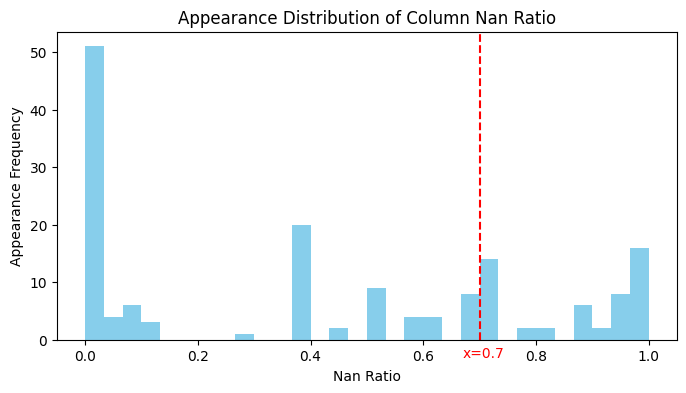

In [7]:
plt.figure(figsize=(8, 4))
plt.hist(df_nan_ratio.values.flatten(), bins=30, range=(0, 1), color='skyblue')
plt.title('Appearance Distribution of Column Nan Ratio')
plt.xlabel('Nan Ratio')
plt.ylabel('Appearance Frequency')
plt.axvline(x=0.7, color='red', linestyle='--')
plt.text(0.67, -3, 'x=0.7', color='red')
plt.show()

After setting the threshold, filter the data and only use columns that has less 70% missing values 

In [8]:
df_nan_ratio = df.isnull().sum(axis=0) / len(df)
new_df_c_cleaning = df.loc[:, df_nan_ratio <= 0.7]
new_df_c_cleaning.shape

(50920, 112)

## Clean row data (patients instances)
Then do the same thing for patients that have too few data for existing columns/indicators.
Here I set the threshold to 0.5 since most patients have more than 50% data that not nan.

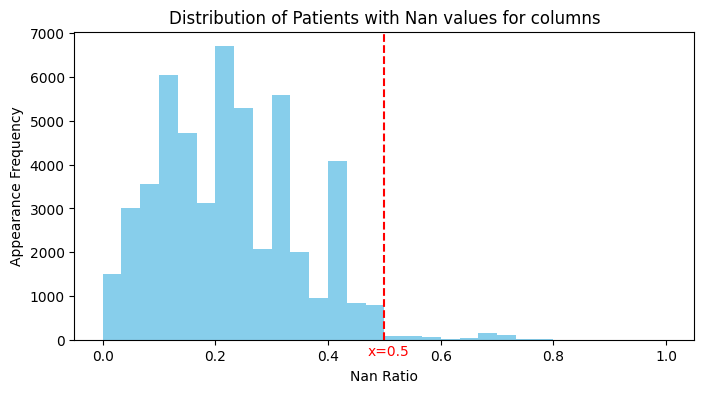

In [9]:
new_df_nan_ratio = new_df_c_cleaning.isnull().sum(axis=1) / len(new_df_c_cleaning.columns)
plt.figure(figsize=(8, 4))
plt.hist(new_df_nan_ratio.values, bins=30, range=(0, 1), color='skyblue')
plt.title('Distribution of Patients with Nan values for columns')
plt.xlabel('Nan Ratio')
plt.ylabel('Appearance Frequency')
plt.axvline(x=0.5, color='red', linestyle='--')
plt.text(0.47, -350, 'x=0.5', color='red')
plt.show()

Check out the new data after row cleaning

In [10]:
new_df_r_cleaning = new_df_c_cleaning.loc[new_df_nan_ratio <= 0.5,:]
print(new_df_r_cleaning.shape)
new_df_r_cleaning.head()


(50372, 112)


,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,bilirubin_total_max,ck_cpk_min,ck_cpk_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,36570066,3,F,79.953141,BLACK/AFRICAN AMERICAN,96.0,104.0,100.083333,103.0,126.0,...,17.0,NaN,NaN,15.0,6.0,5.0,4.0,0.0,157.0,110.0
1,39307659,0,F,78.194169,WHITE - RUSSIAN,72.0,134.0,97.263158,97.0,127.0,...,2.9,175.0,175.0,15.0,6.0,5.0,4.0,0.0,NaN,82.0
2,38743306,2,F,65.602396,WHITE,60.0,97.0,84.166667,95.0,143.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,62.1
3,32339865,2,F,64.906629,UNKNOWN,59.0,87.0,71.461538,113.0,150.0,...,0.7,NaN,NaN,15.0,1.0,0.0,1.0,1.0,170.0,113.1
4,35526987,2,M,57.438861,WHITE,57.0,100.0,82.387097,81.0,127.0,...,0.6,NaN,NaN,15.0,NaN,0.0,1.0,1.0,178.0,97.4


## Column Value Adjust
For column with name "race", I need to categorize each row as there are some ambiguous and repeatitive items inside.

In [31]:
new_df_after_cleaning = new_df_r_cleaning.copy()

for index, row in new_df_after_cleaning.iterrows():
    if "BLACK" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "BLACK"
    elif "WHITE" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "WHITE"
    elif "ASIAN" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "ASIAN"
    elif "HISPANIC" in row['race'] or "SOUTH AMERICAN" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "HISPANIC"
    elif "UNABLE" in row['race'] or "UNKNOWN" in row['race'] or "DECLINED" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "UNKNOWN"
    elif "PORTUGUESE" in row['race']:
        new_df_after_cleaning.at[index, 'race'] = "UNKNOWN"

new_df_after_cleaning.head()

,id,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,...,bilirubin_total_max,ck_cpk_min,ck_cpk_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,36570066,3,F,79.953141,BLACK,96.0,104.0,100.083333,103.0,126.0,...,17.0,NaN,NaN,15.0,6.0,5.0,4.0,0.0,157.0,110.0
1,39307659,0,F,78.194169,WHITE,72.0,134.0,97.263158,97.0,127.0,...,2.9,175.0,175.0,15.0,6.0,5.0,4.0,0.0,NaN,82.0
2,38743306,2,F,65.602396,WHITE,60.0,97.0,84.166667,95.0,143.0,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,62.1
3,32339865,2,F,64.906629,UNKNOWN,59.0,87.0,71.461538,113.0,150.0,...,0.7,NaN,NaN,15.0,1.0,0.0,1.0,1.0,170.0,113.1
4,35526987,2,M,57.438861,WHITE,57.0,100.0,82.387097,81.0,127.0,...,0.6,NaN,NaN,15.0,NaN,0.0,1.0,1.0,178.0,97.4


## Column Trim
1. Transform non-numeric data for column "race" to numeric data, start from 0
2. Column Trim for useless column "id"

In [32]:
list_unique_races = new_df_after_cleaning['race'].unique()
print(list_unique_races)
num_unique_races = len(list_unique_races)
new_df_after_cleaning['race'] = new_df_after_cleaning['race'].replace(list_unique_races,[i for i in range(num_unique_races)])
new_df_after_cleaning['gender'] = new_df_after_cleaning['gender'].replace(['M','F'],[0,1])

# The id column is useless, so I can get rid of it.
new_df_trim =  new_df_after_cleaning.drop(labels = ['id'], axis = 1)
print(new_df_trim.shape)

new_df_trim.head()


['BLACK' 'WHITE' 'UNKNOWN' 'ASIAN' 'OTHER' 'HISPANIC'
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'AMERICAN INDIAN/ALASKA NATIVE' 'MULTIPLE RACE/ETHNICITY']
(50372, 111)


,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,...,bilirubin_total_max,ck_cpk_min,ck_cpk_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,3,1,79.953141,0,96.0,104.0,100.083333,103.0,126.0,116.136364,...,17.0,NaN,NaN,15.0,6.0,5.0,4.0,0.0,157.0,110.0
1,0,1,78.194169,1,72.0,134.0,97.263158,97.0,127.0,109.833333,...,2.9,175.0,175.0,15.0,6.0,5.0,4.0,0.0,NaN,82.0
2,2,1,65.602396,1,60.0,97.0,84.166667,95.0,143.0,112.153846,...,NaN,NaN,NaN,15.0,6.0,5.0,4.0,0.0,NaN,62.1
3,2,1,64.906629,2,59.0,87.0,71.461538,113.0,150.0,138.160000,...,0.7,NaN,NaN,15.0,1.0,0.0,1.0,1.0,170.0,113.1
4,2,0,57.438861,1,57.0,100.0,82.387097,81.0,127.0,97.672131,...,0.6,NaN,NaN,15.0,NaN,0.0,1.0,1.0,178.0,97.4


## Data Imputation
Impute data for those grids with Nan value with mean value of associated columns 

In [34]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(new_df_trim)
new_df_impute = pd.DataFrame(imp_mean.transform(new_df_trim), columns=new_df_trim.columns)
print(new_df_impute.shape)
new_df_impute.head()

(50372, 111)


,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,...,bilirubin_total_max,ck_cpk_min,ck_cpk_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,3.0,1.0,79.953141,0.0,96.0,104.0,100.083333,103.0,126.0,116.136364,...,17.000000,843.785174,1439.626954,15.0,6.000000,5.0,4.0,0.0,157.000000,110.0
1,0.0,1.0,78.194169,1.0,72.0,134.0,97.263158,97.0,127.0,109.833333,...,2.900000,175.000000,175.000000,15.0,6.000000,5.0,4.0,0.0,169.633518,82.0
2,2.0,1.0,65.602396,1.0,60.0,97.0,84.166667,95.0,143.0,112.153846,...,1.764892,843.785174,1439.626954,15.0,6.000000,5.0,4.0,0.0,169.633518,62.1
3,2.0,1.0,64.906629,2.0,59.0,87.0,71.461538,113.0,150.0,138.160000,...,0.700000,843.785174,1439.626954,15.0,1.000000,0.0,1.0,1.0,170.000000,113.1
4,2.0,0.0,57.438861,1.0,57.0,100.0,82.387097,81.0,127.0,97.672131,...,0.600000,843.785174,1439.626954,15.0,5.166369,0.0,1.0,1.0,178.000000,97.4


# Data Label
1. Label the patients with aki >0 as kidney failure.
2. Label the patients with aki=0 as normal
Then aki = 1.0 means having kidney failure, aki = 0.0 means normal

In [44]:
for index, row in new_df_impute.iterrows():
    if row['aki'] > 0:
        row['aki'] = 1.0

new_df_impute.head()

,aki,gender,admission_age,race,heart_rate_min,heart_rate_max,heart_rate_mean,sbp_min,sbp_max,sbp_mean,...,bilirubin_total_max,ck_cpk_min,ck_cpk_max,gcs_min,gcs_motor,gcs_verbal,gcs_eyes,gcs_unable,height,weight_admit
0,1.0,1.0,79.953141,0.0,96.0,104.0,100.083333,103.0,126.0,116.136364,...,17.000000,843.785174,1439.626954,15.0,6.000000,5.0,4.0,0.0,157.000000,110.0
1,0.0,1.0,78.194169,1.0,72.0,134.0,97.263158,97.0,127.0,109.833333,...,2.900000,175.000000,175.000000,15.0,6.000000,5.0,4.0,0.0,169.633518,82.0
2,1.0,1.0,65.602396,1.0,60.0,97.0,84.166667,95.0,143.0,112.153846,...,1.764892,843.785174,1439.626954,15.0,6.000000,5.0,4.0,0.0,169.633518,62.1
3,1.0,1.0,64.906629,2.0,59.0,87.0,71.461538,113.0,150.0,138.160000,...,0.700000,843.785174,1439.626954,15.0,1.000000,0.0,1.0,1.0,170.000000,113.1
4,1.0,0.0,57.438861,1.0,57.0,100.0,82.387097,81.0,127.0,97.672131,...,0.600000,843.785174,1439.626954,15.0,5.166369,0.0,1.0,1.0,178.000000,97.4


## Data Split
Split the data into train_set and test_set. Here, 30% of data will be test set and 70% will be train set.

In [58]:
X = new_df_impute.drop(columns=['aki'])
y = new_df_impute['aki'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

X_train: (35260, 110) X_test: (15112, 110)
y_train: (35260,) y_test: (15112,)


# Feature Selection

In [ ]:
new_df = new_df_impute.copy()
clf = LogisticRegression(solver='saga')
# Use the genetic algorithm for feature selection
selector = GeneticSelectionCV(clf,
                              cv=5,
                              verbose=1,
                              scoring="f1",
                              max_features=30,
                              n_population=50,
                              crossover_proba=0.5,
                              mutation_proba=0.2,
                              n_generations=50,
                              crossover_independent_proba=0.5,
                              mutation_independent_proba=0.05,
                              tournament_size=3,
                              caching=True,
                              n_jobs=-1)


# Select the best features using the genetic algorithm
selector.fit(X_train, y_train)

# Select the features in the original dataset
selected_features = new_df.columns[selector.support_]
print(len(selected_features))
print("Selected features Results: ",selected_features)